<a href="https://colab.research.google.com/github/Bahrombekk/pytorch/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Object_detection(Cat_and_Dog)_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-10-31 17:18:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.207, 142.250.97.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   158MB/s    in 0.4s    

2023-10-31 17:18:38 (158 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip -d data cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
replace data/cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/cats_and_dogs_filtered/vectorize.py  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: data/cats_and_dogs_filtered/validation/dogs/dog.2117.jpg  
  inflating: data/cats_an

In [ ]:
!pip install torchinfo

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader,random_split
import torch.nn.functional as F
import glob

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
# from torchinfo import summary
from torchsummary import summary
import pathlib
from PIL import Image
from torchvision.transforms import transforms
from torch.optim import Adam

import torchvision.transforms as T

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# DATA PREPARATION

In [ ]:
train_path = pathlib.Path('/content/data/cats_and_dogs_filtered/train')
test_path = pathlib.Path('/content/data/cats_and_dogs_filtered/validation')

In [ ]:
transform = T.Compose([
    T.Resize(size=(150,150)),
    T.ToTensor()
])

In [ ]:
class CATinDOGtaset(Dataset):

    def __init__(self, path, transform = None):
        # int for cross entryp loss
        self.path_list = list(path.glob('*/*.jpg'))
        self.transform = transform

    def __getitem__(self,index):
        img = Image.open(self.path_list[index])
        label = (self.path_list[index]).parts[-2]
        label = 0 if 'cat' in label else 1
        if transform != None:
            img = transform(img)

        return img, int(label)

    def __len__(self):
        return len(self.path_list)

In [ ]:
train_dataset = CATinDOGtaset(train_path, transform)
test_dataset = CATinDOGtaset(test_path, transform)

path_list = list(train_path.glob('*/*.jpg'))
path_test=list(test_path.glob('*/*.jpg'))

train_data = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_data = DataLoader(test_dataset, batch_size=256, shuffle=True)

# MODEL

In [ ]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=2):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)

        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)

        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)

        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)

        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)

        #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)

        output=self.fc(output)

        return output


In [ ]:
model=ConvNet()
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
num_epochs = 15

In [ ]:
class Trainer:
    def __init__(self, model, train_dataloader, test_dataloader, criterion, optimizer, epochs=3):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.criterion = criterion
        self.optimizer = optimizer

        self.epochs = epochs
        self.history = {'loss':[],'acc':[],'val_loss':[],'val_acc':[]}

    def train_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.train_dataloader)
        for i, (data,label) in enumerate(tqdm(self.train_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)

            sum_loss += loss.item()
            n_corrects = (output.argmax(axis=1)==label).sum().item()
            sum_accuracy += n_corrects/label.size(0)

            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


        train_loss = sum_loss/n
        train_accuracy = sum_accuracy/n

        self.history['loss'].append(train_loss)
        self.history['acc'].append(train_accuracy)

        return train_loss, train_accuracy

    def validation_loop(self):
        sum_loss = 0
        sum_accuracy = 0
        n = len(self.test_dataloader)
        for i, (data,label) in enumerate(tqdm(self.test_dataloader)):
            data = data.to(device)
            label = label.to(device)
            # prediction model
            output = self.model(data)
            # find loss
            loss = self.criterion(output, label)
            n_corrects = (output.argmax(axis=1)==label).sum().item()

            sum_loss += loss.item()
            sum_accuracy += n_corrects/label.size(0)

        val_loss = sum_loss/n
        val_accuracy = sum_accuracy/n

        self.history['val_loss'].append(val_loss)
        self.history['val_acc'].append(val_accuracy)

        return val_loss, val_accuracy

    def train(self):
        for epoch in range(num_epochs):
            train_loss, train_acc = self.train_loop()
            val_loss, val_acc = self.validation_loop()
            print()
            print(f'Epoch[{epoch+1}/{num_epochs}] \t train_loss: {train_loss:.5f}, train_acc: {train_acc:.2f} \t val_loss: {val_loss:.5f} \t val_acc: {val_acc:.2}')


In [ ]:
trainer = Trainer(
    model = model.to(device),
    train_dataloader = train_data,
    test_dataloader = test_data,
    criterion=criterion,
    optimizer=optimizer
)

In [ ]:
trainer.train()

100%|██████████| 4/4 [00:18<00:00,  4.74s/it]



Epoch[1/15] 	 train_loss: 22.35467, train_acc: 0.52 	 val_loss: 24.82823 	 val_acc: 0.5


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]



Epoch[2/15] 	 train_loss: 14.94476, train_acc: 0.53 	 val_loss: 15.42946 	 val_acc: 0.52


100%|██████████| 4/4 [00:16<00:00,  4.14s/it]



Epoch[3/15] 	 train_loss: 8.91161, train_acc: 0.57 	 val_loss: 9.81682 	 val_acc: 0.53


100%|██████████| 4/4 [00:17<00:00,  4.41s/it]



Epoch[4/15] 	 train_loss: 5.19626, train_acc: 0.61 	 val_loss: 2.91934 	 val_acc: 0.63


100%|██████████| 4/4 [00:16<00:00,  4.24s/it]



Epoch[5/15] 	 train_loss: 2.29598, train_acc: 0.71 	 val_loss: 3.43820 	 val_acc: 0.6


100%|██████████| 4/4 [00:16<00:00,  4.11s/it]



Epoch[6/15] 	 train_loss: 1.16322, train_acc: 0.78 	 val_loss: 2.07124 	 val_acc: 0.63


100%|██████████| 4/4 [00:16<00:00,  4.02s/it]



Epoch[7/15] 	 train_loss: 0.53518, train_acc: 0.84 	 val_loss: 1.48545 	 val_acc: 0.64


100%|██████████| 4/4 [00:16<00:00,  4.05s/it]



Epoch[8/15] 	 train_loss: 0.26655, train_acc: 0.90 	 val_loss: 1.25328 	 val_acc: 0.67


100%|██████████| 4/4 [00:19<00:00,  4.77s/it]



Epoch[9/15] 	 train_loss: 0.16221, train_acc: 0.93 	 val_loss: 1.62128 	 val_acc: 0.64


100%|██████████| 4/4 [00:16<00:00,  4.23s/it]



Epoch[10/15] 	 train_loss: 0.15122, train_acc: 0.94 	 val_loss: 1.29830 	 val_acc: 0.67


100%|██████████| 4/4 [00:16<00:00,  4.20s/it]



Epoch[11/15] 	 train_loss: 0.07229, train_acc: 0.97 	 val_loss: 1.26100 	 val_acc: 0.67


100%|██████████| 4/4 [00:16<00:00,  4.10s/it]



Epoch[12/15] 	 train_loss: 0.04775, train_acc: 0.99 	 val_loss: 1.18542 	 val_acc: 0.67


100%|██████████| 4/4 [00:15<00:00,  4.00s/it]



Epoch[13/15] 	 train_loss: 0.02659, train_acc: 1.00 	 val_loss: 1.16808 	 val_acc: 0.67


100%|██████████| 4/4 [00:16<00:00,  4.03s/it]



Epoch[14/15] 	 train_loss: 0.01906, train_acc: 1.00 	 val_loss: 1.18867 	 val_acc: 0.67


100%|██████████| 4/4 [00:16<00:00,  4.02s/it]


Epoch[15/15] 	 train_loss: 0.01447, train_acc: 1.00 	 val_loss: 1.22483 	 val_acc: 0.67


In [ ]:
test_img, test_label = next(iter(test_data))
pred = model(test_img.to(device))
pred = pred.argmax(axis=1)
pred.device
pred = pred.detach().cpu()
from sklearn.metrics import confusion_matrix
test_label

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
cm = confusion_matrix(test_label, pred)
cm

array([[106,  33],
       [ 39,  78]])

<Axes: >

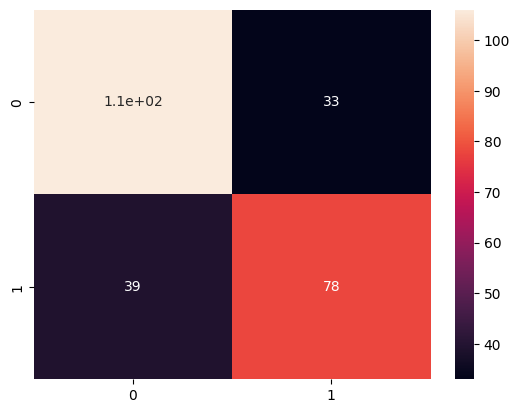

In [ ]:
import seaborn as sns
sns.heatmap(cm, annot=True)

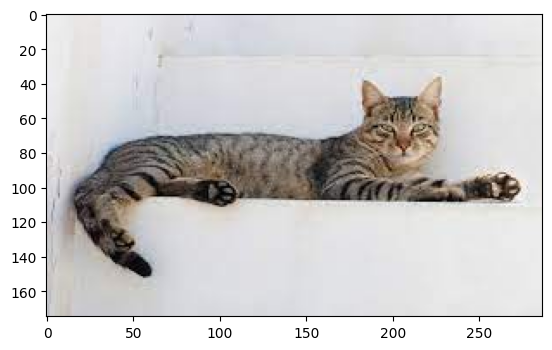

'cat'

In [ ]:
import cv2
def generate_label(image_path):
    # Load and preprocess the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Pass the image through the model
    output = model(image_tensor)

    # Get the predicted label
    predicted_label = output.argmax(dim=1).item()
    label_mapping = {0: 'cat', 1: 'dog'}
    label = label_mapping[predicted_label]
    img=cv2.imread(image_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

    return label
generate_label("/content/download.jpg")

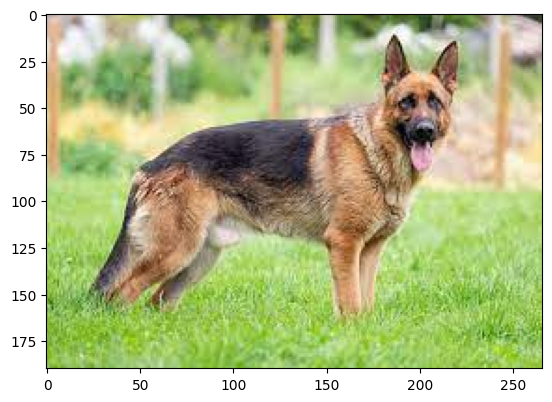

'dog'

In [ ]:
generate_label("/content/download (1).jpg")